In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [5]:
df = pd.read_csv("dataset/resize_borvo.csv") 

grid = {}
for _, row in df.iterrows():
    grid[(int(row["i"]), int(row["j"]))] = {"H": row["H"], "W": row["W"]}

grid

{(0, 0): {'H': np.float64(0.0), 'W': np.float64(84.67376627164963)},
 (0, 1): {'H': np.float64(0.743651), 'W': np.float64(83.1197567499934)},
 (0, 2): {'H': np.float64(0.29696953), 'W': np.float64(84.1069002678753)},
 (0, 3): {'H': np.float64(0.022088643), 'W': np.float64(84.71423903755063)},
 (0, 4): {'H': np.float64(0.16689196), 'W': np.float64(84.43808096854252)},
 (0, 5): {'H': np.float64(0.5374903), 'W': np.float64(83.67861296636154)},
 (0, 6): {'H': np.float64(0.58657616), 'W': np.float64(83.60030193425256)},
 (0, 7): {'H': np.float64(0.33378392), 'W': np.float64(84.1651157872154)},
 (0, 8): {'H': np.float64(0.8197341), 'W': np.float64(83.14987015137437)},
 (0, 9): {'H': np.float64(1.3645873), 'W': np.float64(81.98196060873431)},
 (0, 10): {'H': np.float64(0.79519117), 'W': np.float64(83.25230011905643)},
 (0, 11): {'H': np.float64(0.5546704), 'W': np.float64(83.79240333909188)},
 (0, 12): {'H': np.float64(1.0332576), 'W': np.float64(82.78225934745784)},
 (0, 13): {'H': np.float6

In [4]:
# Fungsi ambil tetangga 8 arah (termasuk diagonal)
def get_all_neighbors(pos):
    i, j = pos
    directions = [
        (-1, -1), (-1, 0), (-1, 1),
        (0, -1),           (0, 1),
        (1, -1), (1, 0), (1, 1)
    ]
    neighbors = [(i + di, j + dj) for di, dj in directions]
    return [n for n in neighbors if n in grid]

# Fungsi hitung skor W/E
def get_score(current_pos, neighbor_pos):
    H1 = grid[current_pos]["H"]
    H2 = grid[neighbor_pos]["H"]
    S = H1 - H2

    if S > 1.5:
        return -np.inf  # Tidak aman → skip

    E = 1 + 1 * abs(S)
    W = grid[neighbor_pos]["W"]
    return W / E

In [6]:
#Algoritma Simulated Annealing
def simulated_annealing_fair(start, Tmax=1000, Tmin=1.0, alpha=0.95, max_iter=500):
    if start not in grid:
        print(f"Titik {start} tidak ditemukan dalam dataset.")
        return []

    current = start
    path = [current]
    visited = set([current])

    current_score = 0

    T = Tmax

    for _ in range(max_iter):
        if T < Tmin:
            break

        neighbors = get_all_neighbors(current)
        valid_neighbors = [n for n in neighbors if n not in visited]

        if not valid_neighbors:
            break

        next_ = random.choice(valid_neighbors)
        score = get_score(current, next_)
        if score == -np.inf:
            continue

        delta = score

        # Aturan SA: selalu terima jika lebih baik, atau probabilistik jika lebih buruk
        if delta > 0 or random.random() < np.exp(delta / T):
            current = next_
            current_score += score
            path.append(current)
            visited.add(current)

        T *= alpha

    return path


In [53]:
# Titik uji coba
test_points = [
    (248,148),
    (20/2, 502/2),
    (410//2, 915//2),
]

def analyze_path(path, E_max=500):
    total_E = 0
    total_W = 0

    for i in range(len(path) - 1):
        curr = path[i]
        nxt = path[i + 1]

        H1 = grid[curr]["H"]
        H2 = grid[nxt]["H"]
        S = abs(H1 - H2)
        E = 1 + 1 * S  # asumsikan k = 1

        W = grid[nxt]["W"]

        total_E += E
        total_W += W

    E_sisa = E - total_E
    W_last = grid[path[-1]]["W"] if path else 0

    return {
        "total_energy_used": total_E,
        "energy_remaining": E_sisa,
        "total_water_collected": total_W,
        "water_at_last_point": W_last
    }


# Jalankan algoritma untuk semua titik uji
for idx, point in enumerate(test_points, 1):
    print(f"\n=== Titik {idx} - Start di {point} ===")
    #kalau mau hasil yang beda pake seed yang beda, tapi jangan lupa buat ganti seed di visualisasi mapnya jg
    #seed bagus sejauh ini: 3,10,23,38
    random.seed(23 + idx)
    path = simulated_annealing_fair(point)

    print(f"Jumlah langkah: {len(path)}")
    print("Jalur dan Skor per langkah:")

    total_score = 0
    for i in range(len(path) - 1):
        curr = path[i]
        nxt = path[i+1]
        score = get_score(curr, nxt)
        total_score += score
        print(f"{curr} → {nxt} | Skor: {score:.2f}")
    
    print(f"Total skor kumulatif W/E: {total_score:.2f}")
    
    summary = analyze_path(path)
    print(f"Total Energi Digunakan: {summary['total_energy_used']:.2f}")
    print(f"Energi Tersisa: {summary['energy_remaining']:.2f}")
    print(f"Total Kadar Air Ditemukan: {summary['total_water_collected']:.2f}")
    print(f"Kadar Air di Titik Akhir: {summary['water_at_last_point']:.2f}")


=== Titik 1 - Start di (248, 148) ===
Jumlah langkah: 136
Jalur dan Skor per langkah:
(248, 148) → (249, 148) | Skor: 72.39
(249, 148) → (250, 149) | Skor: 87.91
(250, 149) → (251, 148) | Skor: 55.75
(251, 148) → (250, 148) | Skor: 63.97
(250, 148) → (249, 149) | Skor: 76.29
(249, 149) → (248, 150) | Skor: 60.80
(248, 150) → (247, 150) | Skor: 89.75
(247, 150) → (246, 150) | Skor: 88.22
(246, 150) → (247, 149) | Skor: 78.92
(247, 149) → (246, 148) | Skor: 87.70
(246, 148) → (247, 147) | Skor: 73.96
(247, 147) → (246, 147) | Skor: 67.95
(246, 147) → (247, 148) | Skor: 86.54
(247, 148) → (248, 147) | Skor: 85.73
(248, 147) → (247, 146) | Skor: 87.47
(247, 146) → (248, 145) | Skor: 85.05
(248, 145) → (248, 146) | Skor: 81.40
(248, 146) → (247, 145) | Skor: 80.75
(247, 145) → (246, 144) | Skor: 85.98
(246, 144) → (246, 145) | Skor: 77.21
(246, 145) → (245, 145) | Skor: 77.86
(245, 145) → (245, 144) | Skor: 77.01
(245, 144) → (245, 143) | Skor: 75.68
(245, 143) → (246, 143) | Skor: 93.22
(

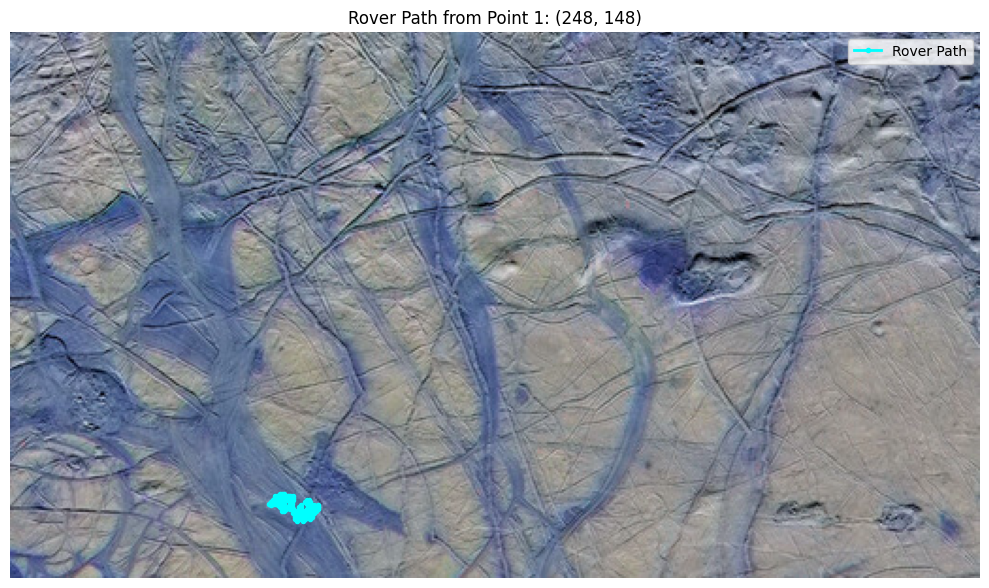

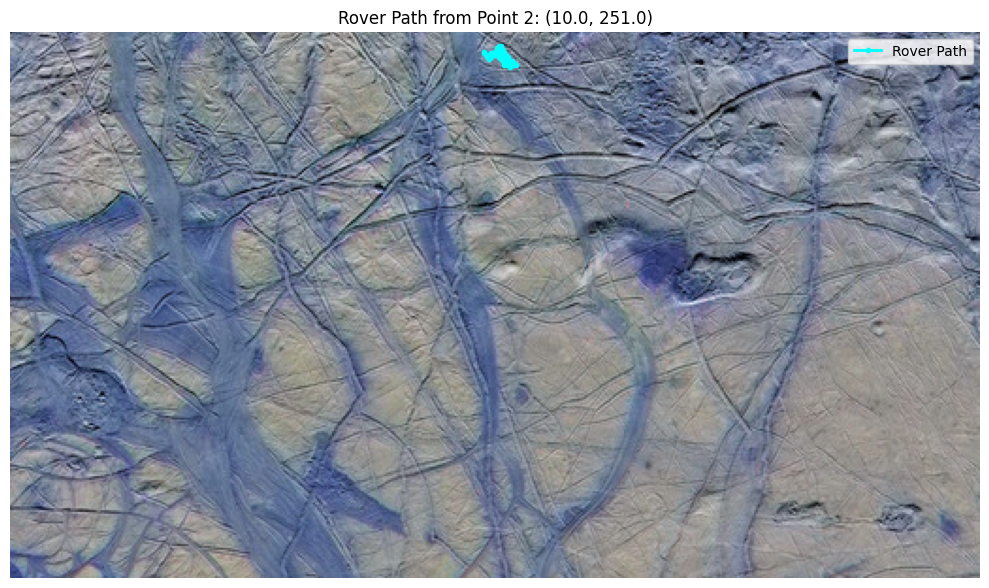

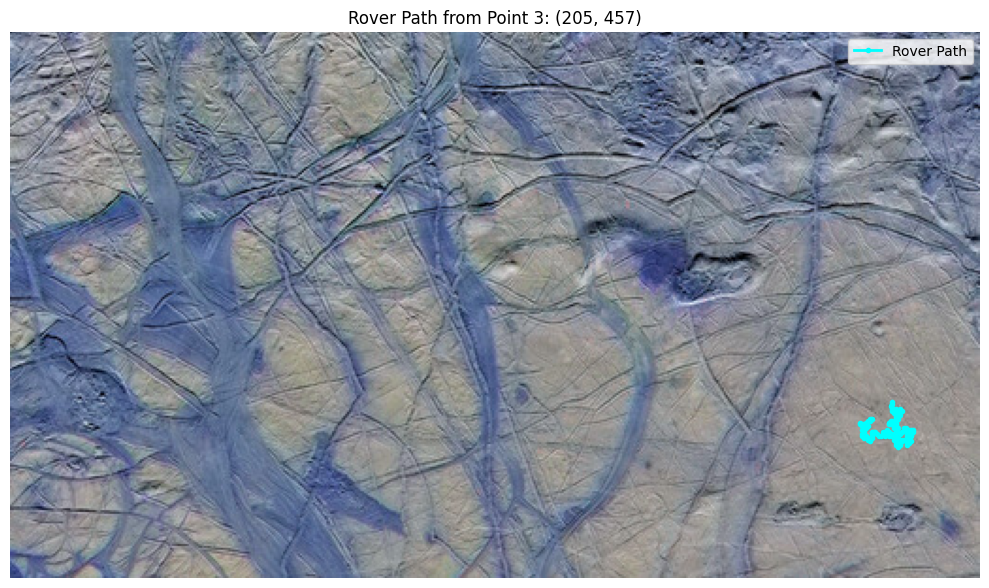

In [54]:
import matplotlib.pyplot as plt
import cv2

# Muat gambar height map dan konversi ke grayscale
img = cv2.imread("europa_map/raw/resize_borvo_mensa.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
H_map = cv2.Sobel(gray, cv2.CV_64F, 1, 1, ksize=5)  # Representasi elevasi sederhana

# Visualisasi jalur untuk semua titik uji coba
for idx, point in enumerate(test_points, 1):
    
    #kalau mau hasil yang beda pake seed yang beda, tapi jangan lupa buat ganti seed di kode algo SA nya jg
    #seed bagus sejauh ini: 3,10,23,38
    random.seed(23 + idx)
    path = simulated_annealing_fair(point)
    path_x = [j for i, j in path]  # j = x-axis
    path_y = [i for i, j in path]  # i = y-axis

    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.plot(path_x, path_y, color="cyan", marker="o", linewidth=2, markersize=3, label="Rover Path")
    plt.title(f"Rover Path from Point {idx}: {point}")
    plt.legend()
    plt.axis("off")
    plt.tight_layout()
    plt.show()
